In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['font.family'] = "Times New Roman"

In [27]:
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, 
                                     RepeatedStratifiedKFold, cross_validate)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn import pipeline
from sklearn.feature_selection import SelectFromModel

In [4]:
RANDOM_STATE = 0

In [10]:
dat_cits = pd.read_csv("data/ml_data.csv")

In [12]:
X_supp = pd.get_dummies(dat_cits.dropna().drop(columns=['EVOL_METASTASIS']), columns=['SEX']).values
y_supp = dat_cits.dropna().loc[:,'EVOL_METASTASIS'].values

In [23]:
clf = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
scaler = RobustScaler()
ros = RandomOverSampler(random_state=RANDOM_STATE)
feat = SelectFromModel(LogisticRegression(C=0.1, class_weight='balanced', penalty='l2', random_state=RANDOM_STATE),
                       threshold=-np.inf)

scoring = {'acc': 'accuracy',
           'bac': 'balanced_accuracy',
           'rec': 'recall',
           'prec': 'precision',
          'roc':'roc_auc',
          'avg': 'average_precision',
          'f1w':'f1_weighted'}

In [28]:
pip = pipeline.Pipeline([('scaler', scaler), ('ros', ros), ('feat', feat), ('clf', clf)])    

param_grid_supp = {'clf__C':np.logspace(-3, 2, 10)}
param_grid_supp['feat__max_features'] = range(1, X_supp.shape[1] + 1)

grid = GridSearchCV(estimator=pip, 
                    param_grid=param_grid_supp, 
                    scoring='balanced_accuracy', iid=False,
                    cv= StratifiedKFold(n_splits=10, random_state=RANDOM_STATE))

res_all_conf = cross_validate(grid, X_supp, y_supp, 
                     scoring=scoring, 
                     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=RANDOM_STATE),
                     return_estimator=True,
                     return_train_score= True,
                     verbose=1,
                     n_jobs=6)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  4.6min finished


In [29]:
bacc_supp_1 = res_all_conf['test_bac']

In [30]:
participation= 100*np.array([estim.best_estimator_.named_steps['feat'].get_support() 
                         for estim in res_all_conf['estimator']]).sum(axis=0)/50.0

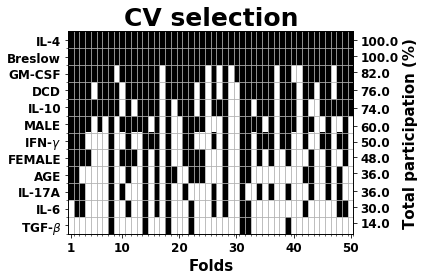

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(1-np.array([estim.best_estimator_.named_steps['feat'].get_support() 
                    for estim in res_all_conf['estimator']]).T[np.argsort(participation)[::-1],:], 
           aspect='auto', cmap='gray')

ax1.set_xlabel("Folds", size=15, fontweight='bold')
ax1.set_xticks([0,9,19,29,39,49])
ax1.set_xticklabels(["1", "10", "20","30","40","50"], size=12, fontweight='bold')

ax1.set_yticks(np.arange(X_supp.shape[1]))
ax1.set_yticklabels(np.array(['Breslow', 'GM-CSF', 'IL-4', 'IL-6', 'IL-10', 
                                   'IL-17A', r'IFN-$\gamma$', r'TGF-$\beta$', 
                              'DCD', 'AGE', 'MALE', 'FEMALE'])[np.argsort(participation)[::-1]],
                   size=12, fontweight='bold')
ax1.set_yticks(0.5 + np.arange(X_supp.shape[1]), minor=True)
ax1.set_xticks(0.5 + np.arange(50), minor=True)
ax1.grid(which='minor')
ax2= ax1.twinx()

ax2.set_ylim([0,9])
ax2.set_yticks([0.5, 1.2, 1.9, 2.7, 3.4, 4.1, 4.8, 5.6, 6.4, 7.2, 7.9, 8.6], minor=False)
ax2.set_yticklabels(participation[np.argsort(participation)],
                   size=12, fontweight='bold', minor=False)
ax1.autoscale(False)
ax2.autoscale(False)
ax2.set_ylabel("Total participation (%)", size=15, fontweight="bold")
plt.title("CV selection", size=25, fontweight="bold")
plt.tight_layout()

## BAYES FACTOR FOR THE THREE DIFFERENT MODELS?

As a way of comparing our proposed scenario, let's compute the BIC for three 

In [42]:
X_model_1 = pd.get_dummies(dat_cits.dropna().drop(columns=['EVOL_METASTASIS']), 
                          columns=['SEX']).loc[:, ['HIST_BRESLOW_mm', 'GM-CSF', 'IL-4', 'Dermicidina']].values

X_model_2 = pd.get_dummies(dat_cits.dropna().drop(columns=['EVOL_METASTASIS']), 
                          columns=['SEX']).loc[:, ['HIST_BRESLOW_mm', 'GM-CSF', 'IL-4', 'Dermicidina', 
                                                   'AGE', 'SEX_0', 'SEX_1']].values.astype(float)
X_model_3 = pd.get_dummies(dat_cits.dropna().drop(columns=['EVOL_METASTASIS']), 
                          columns=['SEX']).loc[:, ['HIST_BRESLOW_mm', 'AGE', 'SEX_0', 'SEX_1']].values.astype(float)
y_bic = dat_cits.dropna().loc[:, 'EVOL_METASTASIS'].values

In [38]:
clf = LogisticRegression(class_weight='balanced')
pip = pipeline.Pipeline([('scaler', scaler), ('clf', clf)])    

grid = GridSearchCV(estimator=pip, 
                    param_grid={'clf__C':[1.0]} , 
                    scoring='balanced_accuracy', iid=False,
                    cv= StratifiedKFold(n_splits=10, random_state=RANDOM_STATE))

In [40]:
from sklearn.linear_model.logistic import _logistic_loss
grid.fit(X_model_1, y_bic)
print(grid.best_score_)

X_model_1_trans = scaler.fit_transform(X_model_1)

coef_ = np.squeeze(grid.best_estimator_.named_steps['clf'].coef_)
alpha = 1 / grid.best_estimator_.named_steps['clf'].C

P1 = np.exp(-_logistic_loss(coef_, X_model_1_trans, y_bic, alpha))

n, k = X_model_1_trans.shape
BIC_1 = -2*np.log(P1) + k*np.log(n)

0.8102164502164502


In [41]:
grid.fit(X_model_2, y_bic)
print(grid.best_score_)


X_model_2_trans = scaler.fit_transform(X_model_2)

coef_ = np.squeeze(grid.best_estimator_.named_steps['clf'].coef_)
alpha = 1 / grid.best_estimator_.named_steps['clf'].C

P2 = np.exp(-_logistic_loss(coef_, X_model_2_trans, y_bic, alpha))
n, k = X_model_2_trans.shape
BIC_2 = -2*np.log(P2) + k*np.log(n)

0.826991341991342


In [43]:
grid.fit(X_model_3, y_bic)
print(grid.best_score_)

X_model_3_trans = scaler.fit_transform(X_model_3)

coef_ = np.squeeze(grid.best_estimator_.named_steps['clf'].coef_)
alpha = 1 / grid.best_estimator_.named_steps['clf'].C

P3 = np.exp(-_logistic_loss(coef_, X_model_3_trans, y_bic, alpha))
n, k = X_model_3_trans.shape
BIC_3 = -2*np.log(P3) + k*np.log(n)

0.7917532467532468


In [44]:
# BICs
print(BIC_1, BIC_2, BIC_3)

(337.1770114645364, 355.735438276381, 343.4349387720011)


In [45]:
B12 = np.exp(0.5*(BIC_2 - BIC_1))
print("Bayes Factor between model with our variable of interest and"
      " the same including also confoundings = %.3f" % B12)

Bayes Factor between model with our variable of interest and the same including also confoundings = 10713.002


In [46]:
B23 = np.exp(0.5*(BIC_3 - BIC_2))

print("Bayes Factor between model with variables of interest and confoundings"
      " and only the confoundings and = %.3f" % B23)

Bayes Factor between model with variables of interest and confoundings and only the confoundings and = 0.002


In [47]:
B13 = np.exp(0.5*(BIC_3 - BIC_1))
print("Bayes Factor between model with the variables of interest"
      " only the confoundings and = %.3f" % B13)

Bayes Factor between model with the variables of interest only the confoundings and = 22.850
